<a href="https://colab.research.google.com/github/kuds/rl-mujoco-tennis/blob/main/%5BBall%20Bounce%5D%20Soft%20Actor%20Critic%20(SAC).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ball Bounce: Soft Actor-Critic (SAC)

## Helpful Links
https://github.com/denisgriaznov/CustomMuJoCoEnviromentForRL

In [1]:
!pip install mujoco

# Set up GPU rendering.
from google.colab import files
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

In [2]:
!pip install stable-baselines3

In [3]:
import gymnasium
import mujoco
from stable_baselines3 import SAC
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import VecVideoRecorder
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.callbacks import CallbackList
import numpy
import os
import csv
import torch
import platform
from importlib.metadata import version
import matplotlib
import matplotlib.pyplot
from gymnasium import utils
from gymnasium.envs.mujoco import MujocoEnv
from gymnasium.spaces import Box

In [4]:
print(f"Python Version: {platform.python_version()}")
print(f"Torch Version: {version('torch')}")
print(f"Is Cuda Available: {torch.cuda.is_available()}")
print(f"Cuda Version: {torch.version.cuda}")
print(f"Gymnasium Version: {version('gymnasium')}")
print(f"Numpy Version: {version('numpy')}")
print(f"Mujoco Version: {version('mujoco')}")
print(f"Stable-Baselines3 Version: {version('stable-baselines3')}")
print(f"Matplotlib Version: {version('matplotlib')}")

Python Version: 3.11.11
Torch Version: 2.5.1+cu124
Is Cuda Available: True
Cuda Version: 12.4
Gymnasium Version: 1.0.0
Numpy Version: 1.26.4
Mujoco Version: 3.3.0
Stable-Baselines3 Version: 2.5.0
Matplotlib Version: 3.10.0


In [5]:
rl_type = "SAC"
env_str = "BallBounce"
log_dir = "./logs/{}".format(env_str)
name_prefix = "ball_bounce"

In [6]:
hyperparams = {
    "env_str": env_str,
    "rl_type": rl_type,
    "eval_freq": 25_000,
    "n_envs": 4,
    "min_force": 100.0,
    "total_timesteps": 2_000_000,
    "log_dir": log_dir,
    "episode_length": 1_000
}

In [7]:
class VideoRecordCallback(BaseCallback):
    def __init__(
        self,
        save_path: str,
        video_length: int,
        save_freq: int = 5_000,
        name_prefix: str ="rl_model",
        verbose: int = 0):

        super().__init__(verbose)
        self.save_freq = save_freq
        self.video_length = video_length
        self.save_path = save_path
        self.name_prefix = name_prefix
        # Those variables will be accessible in the callback
        # (they are defined in the base class)
        # The RL model
        # self.model = None  # type: BaseAlgorithm
        # An alias for self.model.get_env(), the environment used for training
        # self.training_env # type: VecEnv
        # Number of time the callback was called
        # self.n_calls = 0  # type: int
        # num_timesteps = n_envs * n times env.step() was called
        # self.num_timesteps = 0  # type: int
        # local and global variables
        # self.locals = {}  # type: Dict[str, Any]
        # self.globals = {}  # type: Dict[str, Any]
        # The logger object, used to report things in the terminal
        # self.logger # type: stable_baselines3.common.logger.Logger
        # Sometimes, for event callback, it is useful
        # to have access to the parent object
        # self.parent = None  # type: Optional[BaseCallback]

    def _on_step(self) -> bool:
        if self.n_calls % self.save_freq == 0:

          name_prefix = f"{self.name_prefix}_{self.num_timesteps}"

          # Record video of the best model playing
          rec_val = make_vec_env(make_env, n_envs=1)
          rec_val = VecVideoRecorder(rec_val,
                                    self.save_path,
                                    video_length=self.video_length,
                                    record_video_trigger=lambda x: x == 0,
                                    name_prefix=name_prefix)

          obs = rec_val.reset()
          session_length = 0
          total_reward = 0.0
          csv_file_name = os.path.join(self.save_path, f"{name_prefix}.csv")
          with open(csv_file_name, 'w') as csvfile:
            csv_writer = csv.writer(csvfile, delimiter=',')
            csv_writer.writerow(["Sensor Data",
                                 "Reward",
                                 "Total Reward",
                                 "Done"])
            for _ in range(self.video_length):
              session_length += 1
              action, _states = self.model.predict(obs)
              obs, rewards, dones, info = rec_val.step(action)
              total_reward += rewards
              #print(info)
              csv_writer.writerow([info[0]["sensor_data"],
                                   rewards[0],
                                   total_reward[0],
                                   dones[0]])
              rec_val.render()

              if dones:
                break

          print(f"Step: {self.num_timesteps} | Session Length: {session_length} |Total Bounces: {int(total_reward[0])}")

          rec_val.close()
        return True

In [8]:
class BallBounceEnv(MujocoEnv, utils.EzPickle):
    metadata = {
        "render_modes": [
            "human",
            "rgb_array",
            "depth_array",
        ],
        "render_fps": 100,
    }

    # set default episode_len for truncate episodes
    def __init__(self, episode_len=1_000, min_force=0.0, **kwargs):
        utils.EzPickle.__init__(self, **kwargs)

        self.min_force = min_force
        self.bounce_count = 0
        self.previous_touch_value = 0
        # change shape of observation to your observation space size
        observation_space = Box(low=-numpy.inf, high=np.inf, shape=(18,), dtype=numpy.float64)
        # load your MJCF model with env and choose frames count between actions
        MujocoEnv.__init__(
            self,
            os.path.abspath(f"/content/{name_prefix}.xml"),
            5,
            observation_space=observation_space,
            **kwargs
        )
        self.step_number = 0
        self.episode_len = episode_len

    # determine the reward depending on observation or other properties of the simulation
    def step(self, a):
        reward = 0.0
        self.do_simulation(a, self.frame_skip)
        self.step_number += 1


        # Bounce Detection (CRITICAL)
        current_touch_value = self.data.sensor("touch_sensor").data[0]
        if current_touch_value >= self.min_force and self.previous_touch_value <= 0:  # Check for transition from no contact to contact
            self.bounce_count += 1
            reward = 1.0
            #print(f"Bounce! Total Bounces: {self.bounce_count}")
        self.previous_touch_value = current_touch_value

        obs = self._get_obs()
        done = bool(not np.isfinite(obs).all() or (obs[2] < 0))
        truncated = self.step_number > self.episode_len
        return obs, reward, done, truncated, {"sensor_data": current_touch_value}

    # define what should happen when the model is reset (at the beginning of each episode)
    def reset_model(self):
        self.step_number = 0
        self.bounce_count = 0

        # for example, noise is added to positions and velocities
        qpos = self.init_qpos + self.np_random.uniform(
            size=self.model.nq, low=-0.01, high=0.01
        )
        qvel = self.init_qvel + self.np_random.uniform(
            size=self.model.nv, low=-0.01, high=0.01
        )
        self.set_state(qpos, qvel)
        return self._get_obs()

    # determine what should be added to the observation
    # for example, the velocities and positions of various joints can be obtained through their names, as stated here
    def _get_obs(self):
        obs = np.concatenate((np.array(self.data.joint("ball_freejoint").qpos[:3]),
                              np.array(self.data.joint("ball_freejoint").qvel[:3]),
                              np.array(self.data.joint("rotate_x").qpos),
                              np.array(self.data.joint("rotate_x").qvel),
                              np.array(self.data.joint("rotate_y").qpos),
                              np.array(self.data.joint("rotate_y").qvel),
                              np.array(self.data.joint("rotate_z").qpos),
                              np.array(self.data.joint("rotate_z").qvel),
                              np.array(self.data.joint("slider_x").qpos),
                              np.array(self.data.joint("slider_x").qvel),
                              np.array(self.data.joint("slider_y").qpos),
                              np.array(self.data.joint("slider_y").qvel),
                              np.array(self.data.joint("slider_z").qpos),
                              np.array(self.data.joint("slider_z").qvel)), axis=0)
        return obs

In [9]:
# Ensure environment XML (MuJoCo model) is available
xml_content = """
<mujoco>
  <option timestep=".002" />
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
      rgb2=".2 .3 .4" width="300" height="300" mark="none" />
    <material name="grid" texture="grid" texrepeat="1 1"
      texuniform="true" reflectance=".2" />
  </asset>
  <worldbody>
    <light name="light" pos="0 0 1" />
    <geom name="floor" type="plane" pos="0 0 -0.5" size="2 2 .1" material="grid" />
    <body name="paddle_body" pos="0 0 0">
      <site name="bounce_sensor" pos="0 0 0.025" size="0.21 0.21 0.075" type="box" rgba="1 0 0 .05" />
      <joint name="rotate_x" pos="0 0 0" axis="1 0 0" range="-.3 .3" damping="10" />
      <joint name="rotate_y" pos="0 0 0" axis="0 1 0" range="-.3 .3" damping="10" />
      <joint name="rotate_z" pos="0 0 0" axis="0 0 1" range="-.3 .3" damping="10" />
      <joint axis="0 0 1" limited="true" name="slider_z" range="0 0.5" type="slide" />
      <joint axis="0 1 0" limited="true" name="slider_y" range="-.2 .2" type="slide" />
      <joint axis="1 0 0" limited="true" name="slider_x" range="-.2 .2" type="slide" />
      <geom name="paddle_geom" type="box" size=".2 .2 .02" rgba="0.2 0.2 1 1" solref="0.02 0.07" />
    </body>
    <body name="ball_body" pos="0 0 0.3">
      <freejoint name="ball_freejoint" />
      <geom name="ball_geom" type="sphere" size=".04" rgba="0 1 0 1" solref="0.02 0.07" />
    </body>
  </worldbody>
  <actuator>
    <general name="act_x" joint="rotate_x" ctrlrange="-1 1" gainprm="500 0 0" />
    <general name="act_y" joint="rotate_y" ctrlrange="-1 1" gainprm="500 0 0" />
    <general name="act_z" joint="rotate_z" ctrlrange="-1 1" gainprm="500 0 0" />
    <motor ctrllimited="true" ctrlrange="-1 1" gear="50" joint="slider_z" name="slider_z_motor" />
    <motor ctrllimited="true" ctrlrange="-1 1" gear="50" joint="slider_y" name="slider_y_motor" />
    <motor ctrllimited="true" ctrlrange="-1 1" gear="50" joint="slider_x" name="slider_x_motor" />
  </actuator>
  <sensor>
    <touch name="touch_sensor" site="bounce_sensor" />
  </sensor>
</mujoco>
"""

with open(f"{name_prefix}.xml", "w") as f:
    f.write(xml_content)

In [10]:
env = BallBounceEnv(render_mode="rgb_array")
print("Observation Space Size: ", env.observation_space.shape)
print('Actions Space: ', env.action_space)
env.close()

Observation Space Size:  (18,)
Actions Space:  Box(-1.0, 1.0, (6,), float32)


In [11]:
def make_env():
  env = BallBounceEnv(render_mode="rgb_array",
                      episode_len=hyperparams["episode_length"],
                      min_force=hyperparams["min_force"])
  check_env(env)
  return env

# Create Training environment
env = make_vec_env(make_env,
                   n_envs=hyperparams["n_envs"],
                   monitor_dir=os.path.join(log_dir, "monitor"))

# Create Evaluation environment
env_val = make_vec_env(make_env, n_envs=1)

eval_callback = EvalCallback(env_val,
                             best_model_save_path=log_dir,
                             log_path=log_dir,
                             render=False,
                             deterministic=True,
                             n_eval_episodes=20,
                             eval_freq=hyperparams["eval_freq"])

video_record_callback = VideoRecordCallback(
    save_path=os.path.join(log_dir, "videos"),
    video_length=10_000,
    save_freq=hyperparams["eval_freq"],
    name_prefix=name_prefix)

# Create the callback list
callbackList = CallbackList([video_record_callback,
                             eval_callback])

# learning with tensorboard logging and saving model
model = SAC("MlpPolicy",
            env,
            verbose=0,
            tensorboard_log=os.path.join(log_dir, "tensorboard"))

model.learn(total_timesteps=hyperparams["total_timesteps"],
            callback=callbackList,
            progress_bar=False)

# Save the model
model.save(os.path.join(log_dir, "final_model"))

mean_reward, std_reward = evaluate_policy(model, env)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

env.close()
env_val.close()

Step: 100000 | Session Length: 305 |Total Bounces: 1
Moviepy - Building video /content/logs/BallBounce/videos/ball_bounce_100000-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/logs/BallBounce/videos/ball_bounce_100000-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/BallBounce/videos/ball_bounce_100000-step-0-to-step-10000.mp4
Eval num_timesteps=100000, episode_reward=1.45 +/- 1.43
Episode length: 216.00 +/- 109.03
New best mean reward!
Step: 200000 | Session Length: 351 |Total Bounces: 3
Moviepy - Building video /content/logs/BallBounce/videos/ball_bounce_200000-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/logs/BallBounce/videos/ball_bounce_200000-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/BallBounce/videos/ball_bounce_200000-step-0-to-step-10000.mp4
Eval num_timesteps=200000, episode_reward=1.80 +/- 1.63
Episode length: 228.20 +/- 138.74
New best mean reward!
Step: 300000 | Session Length: 430 |Total Bounces: 2
Moviepy - Building video /content/logs/BallBounce/videos/ball_bounce_300000-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/logs/BallBounce/videos/ball_bounce_300000-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/BallBounce/videos/ball_bounce_300000-step-0-to-step-10000.mp4
Eval num_timesteps=300000, episode_reward=1.95 +/- 1.28
Episode length: 290.35 +/- 124.45
New best mean reward!
Step: 400000 | Session Length: 94 |Total Bounces: 2
Moviepy - Building video /content/logs/BallBounce/videos/ball_bounce_400000-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/logs/BallBounce/videos/ball_bounce_400000-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/BallBounce/videos/ball_bounce_400000-step-0-to-step-10000.mp4
Eval num_timesteps=400000, episode_reward=2.05 +/- 2.11
Episode length: 234.70 +/- 164.78
New best mean reward!
Step: 500000 | Session Length: 153 |Total Bounces: 4
Moviepy - Building video /content/logs/BallBounce/videos/ball_bounce_500000-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/logs/BallBounce/videos/ball_bounce_500000-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/BallBounce/videos/ball_bounce_500000-step-0-to-step-10000.mp4
Eval num_timesteps=500000, episode_reward=1.30 +/- 0.90
Episode length: 189.95 +/- 88.87
Step: 600000 | Session Length: 473 |Total Bounces: 3
Moviepy - Building video /content/logs/BallBounce/videos/ball_bounce_600000-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/logs/BallBounce/videos/ball_bounce_600000-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/BallBounce/videos/ball_bounce_600000-step-0-to-step-10000.mp4
Eval num_timesteps=600000, episode_reward=3.35 +/- 2.63
Episode length: 437.85 +/- 243.47
New best mean reward!
Step: 700000 | Session Length: 890 |Total Bounces: 8
Moviepy - Building video /content/logs/BallBounce/videos/ball_bounce_700000-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/logs/BallBounce/videos/ball_bounce_700000-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/BallBounce/videos/ball_bounce_700000-step-0-to-step-10000.mp4
Eval num_timesteps=700000, episode_reward=5.75 +/- 3.06
Episode length: 701.35 +/- 261.17
New best mean reward!
Step: 800000 | Session Length: 792 |Total Bounces: 2
Moviepy - Building video /content/logs/BallBounce/videos/ball_bounce_800000-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/logs/BallBounce/videos/ball_bounce_800000-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/BallBounce/videos/ball_bounce_800000-step-0-to-step-10000.mp4
Eval num_timesteps=800000, episode_reward=4.20 +/- 3.03
Episode length: 471.30 +/- 282.67
Step: 900000 | Session Length: 727 |Total Bounces: 9
Moviepy - Building video /content/logs/BallBounce/videos/ball_bounce_900000-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/logs/BallBounce/videos/ball_bounce_900000-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/BallBounce/videos/ball_bounce_900000-step-0-to-step-10000.mp4
Eval num_timesteps=900000, episode_reward=4.75 +/- 3.70
Episode length: 578.30 +/- 243.51
Step: 1000000 | Session Length: 1001 |Total Bounces: 6
Moviepy - Building video /content/logs/BallBounce/videos/ball_bounce_1000000-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/logs/BallBounce/videos/ball_bounce_1000000-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/BallBounce/videos/ball_bounce_1000000-step-0-to-step-10000.mp4
Eval num_timesteps=1000000, episode_reward=8.35 +/- 4.54
Episode length: 827.65 +/- 279.26
New best mean reward!
Step: 1100000 | Session Length: 610 |Total Bounces: 4
Moviepy - Building video /content/logs/BallBounce/videos/ball_bounce_1100000-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/logs/BallBounce/videos/ball_bounce_1100000-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/BallBounce/videos/ball_bounce_1100000-step-0-to-step-10000.mp4
Eval num_timesteps=1100000, episode_reward=5.70 +/- 3.41
Episode length: 634.60 +/- 245.61
Step: 1200000 | Session Length: 1001 |Total Bounces: 10
Moviepy - Building video /content/logs/BallBounce/videos/ball_bounce_1200000-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/logs/BallBounce/videos/ball_bounce_1200000-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/BallBounce/videos/ball_bounce_1200000-step-0-to-step-10000.mp4
Eval num_timesteps=1200000, episode_reward=8.30 +/- 3.27
Episode length: 942.85 +/- 130.56
Step: 1300000 | Session Length: 1001 |Total Bounces: 9
Moviepy - Building video /content/logs/BallBounce/videos/ball_bounce_1300000-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/logs/BallBounce/videos/ball_bounce_1300000-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/BallBounce/videos/ball_bounce_1300000-step-0-to-step-10000.mp4
Eval num_timesteps=1300000, episode_reward=6.15 +/- 4.28
Episode length: 730.80 +/- 353.81
Step: 1400000 | Session Length: 1001 |Total Bounces: 13
Moviepy - Building video /content/logs/BallBounce/videos/ball_bounce_1400000-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/logs/BallBounce/videos/ball_bounce_1400000-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/BallBounce/videos/ball_bounce_1400000-step-0-to-step-10000.mp4
Eval num_timesteps=1400000, episode_reward=5.05 +/- 2.87
Episode length: 606.20 +/- 259.76
Step: 1500000 | Session Length: 1001 |Total Bounces: 7
Moviepy - Building video /content/logs/BallBounce/videos/ball_bounce_1500000-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/logs/BallBounce/videos/ball_bounce_1500000-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/BallBounce/videos/ball_bounce_1500000-step-0-to-step-10000.mp4
Eval num_timesteps=1500000, episode_reward=8.70 +/- 1.73
Episode length: 1001.00 +/- 0.00
New best mean reward!
Step: 1600000 | Session Length: 1001 |Total Bounces: 6
Moviepy - Building video /content/logs/BallBounce/videos/ball_bounce_1600000-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/logs/BallBounce/videos/ball_bounce_1600000-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/BallBounce/videos/ball_bounce_1600000-step-0-to-step-10000.mp4
Eval num_timesteps=1600000, episode_reward=9.65 +/- 4.71
Episode length: 868.35 +/- 269.28
New best mean reward!
Step: 1700000 | Session Length: 1001 |Total Bounces: 15
Moviepy - Building video /content/logs/BallBounce/videos/ball_bounce_1700000-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/logs/BallBounce/videos/ball_bounce_1700000-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/BallBounce/videos/ball_bounce_1700000-step-0-to-step-10000.mp4
Eval num_timesteps=1700000, episode_reward=10.90 +/- 2.34
Episode length: 965.65 +/- 85.58
New best mean reward!
Step: 1800000 | Session Length: 397 |Total Bounces: 4
Moviepy - Building video /content/logs/BallBounce/videos/ball_bounce_1800000-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/logs/BallBounce/videos/ball_bounce_1800000-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/BallBounce/videos/ball_bounce_1800000-step-0-to-step-10000.mp4
Eval num_timesteps=1800000, episode_reward=9.75 +/- 4.66
Episode length: 890.55 +/- 231.49
Step: 1900000 | Session Length: 1001 |Total Bounces: 8
Moviepy - Building video /content/logs/BallBounce/videos/ball_bounce_1900000-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/logs/BallBounce/videos/ball_bounce_1900000-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/BallBounce/videos/ball_bounce_1900000-step-0-to-step-10000.mp4
Eval num_timesteps=1900000, episode_reward=9.10 +/- 3.62
Episode length: 933.70 +/- 165.60
Step: 2000000 | Session Length: 1001 |Total Bounces: 11
Moviepy - Building video /content/logs/BallBounce/videos/ball_bounce_2000000-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/logs/BallBounce/videos/ball_bounce_2000000-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/BallBounce/videos/ball_bounce_2000000-step-0-to-step-10000.mp4
Eval num_timesteps=2000000, episode_reward=9.05 +/- 3.77
Episode length: 985.65 +/- 49.64
Mean reward: 8.50 +/- 2.62


In [12]:
# Create Evaluation environment
env_val = make_vec_env(make_env, n_envs=1)

# Load the best model
best_model_path = os.path.join(log_dir, "best_model")
best_model = SAC.load(best_model_path, env=env)

mean_reward, std_reward = evaluate_policy(best_model,
                                          env_val,
                                          n_eval_episodes=20)

print(f"Best Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Record video of the best model
video_length = 10_000
video_file_name = "best_model_{}".format(name_prefix)
env = VecVideoRecorder(env_val, os.path.join(log_dir, "videos"),
                       video_length=video_length,
                       record_video_trigger=lambda x: x == 0,
                       name_prefix=video_file_name)

total_reward = 0
obs = env.reset()
for _ in range(video_length):
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = env.step(action)
    total_reward += rewards
    env.render()
    if dones:
        break

env.close()
print(f"Total reward: {total_reward[0]}")

Best Model - Mean reward: 9.65 +/- 3.55
Moviepy - Building video /content/logs/BallBounce/videos/best_model_ball_bounce-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/logs/BallBounce/videos/best_model_ball_bounce-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/BallBounce/videos/best_model_ball_bounce-step-0-to-step-10000.mp4
Total reward: 9.0


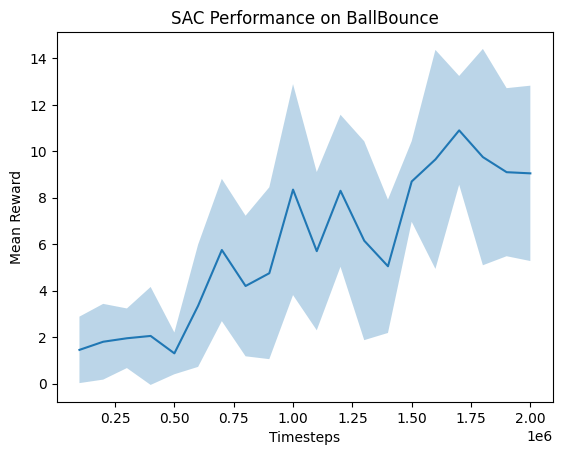

In [13]:
# Load the evaluations.npz file
data = numpy.load(os.path.join(log_dir, "evaluations.npz"))

# Extract the relevant data
timesteps = data['timesteps']
results = data['results']

# Calculate the mean and standard deviation of the results
mean_results = numpy.mean(results, axis=1)
std_results = numpy.std(results, axis=1)

# Plot the results
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(timesteps, mean_results)
matplotlib.pyplot.fill_between(timesteps,
                               mean_results - std_results,
                               mean_results + std_results,
                               alpha=0.3)

matplotlib.pyplot.xlabel('Timesteps')
matplotlib.pyplot.ylabel('Mean Reward')
matplotlib.pyplot.title(f"{rl_type} Performance on {env_str}")
matplotlib.pyplot.show()